In [28]:
import numpy as np
import matplotlib.pyplot as plt
from NeuralNetworks.optimizers import *
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
sns.set(style='darkgrid')


In [24]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.params = {
            'W1': np.random.randn(input_dim, hidden_dim) * 0.01,
            'b1': np.zeros((1, hidden_dim)),
            'W2': np.random.randn(hidden_dim, output_dim) * 0.01,
            'b2': np.zeros((1, output_dim))
        }
    
    def forward(self, X):
        self.cache = {}
        self.cache['Z1'] = X @ self.params['W1'] + self.params['b1']
        self.cache['A1'] = np.maximum(0, self.cache['Z1'])  # ReLU activation
        self.cache['Z2'] = self.cache['A1'] @ self.params['W2'] + self.params['b2']
        return self.cache['Z2']
    
    def backward(self, X, Y):
        m = X.shape[0]
        dZ2 = self.cache['Z2'] - Y
        dW2 = self.cache['A1'].T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = dZ2 @ self.params['W2'].T
        dZ1 = dA1 * (self.cache['Z1'] > 0)
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return grads

    def update_params(self, grads, optimizer):
        for param_name in self.params.keys():
            delta = optimizer.update(param_name, self.params[param_name], grads['d' + param_name])
            self.params[param_name] -= delta

In [54]:
def train_and_plot(optimizer_names, optimizer_params, X_train, y_train, num_epochs=1000):
    input_dim = X_train.shape[1]
    hidden_dim = 10
    output_dim = y_train.shape[1]
    losses = {}

    for optimizer_name in optimizer_names:
        nn = SimpleNN(input_dim, hidden_dim, output_dim)
        optimizer = initialize_optimizer(optimizer_name, **optimizer_params[optimizer_name])
        losses[optimizer_name] = []

        for _ in range(num_epochs):
            logits = nn.forward(X_train)
            loss = np.mean(np.square(logits - y_train))
            losses[optimizer_name].append(loss)

            grads = nn.backward(X_train, y_train)
            nn.update_params(grads, optimizer)
        
     
    num_cols = 2
    num_rows = (len(optimizer_names) + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
    axs = axs.flatten()
    for i, optimizer_name in enumerate(optimizer_names):
        sns.lineplot(x=range(num_epochs), y=losses[optimizer_name], ax=axs[i])
        axs[i].set_title(f'{optimizer_name} Loss Curve')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        
    # Remove any empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()
        

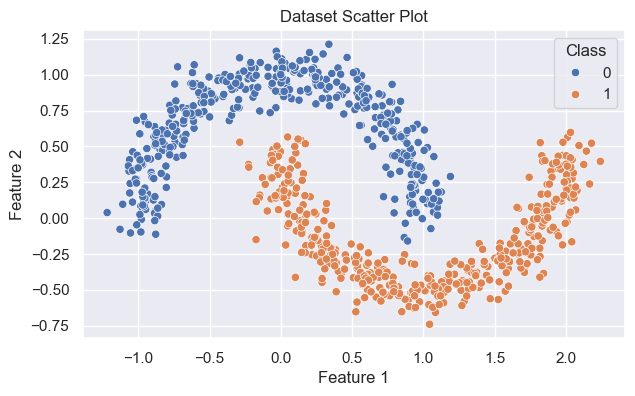

In [61]:
# Generate a toy dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
y = y.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)


y_train_labels = np.argmax(y_train, axis=1)
# Create a scatter plot
plt.figure(figsize=(7,4))
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train_labels, palette="deep")
plt.title("Dataset Scatter Plot")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Class")
plt.show()
    


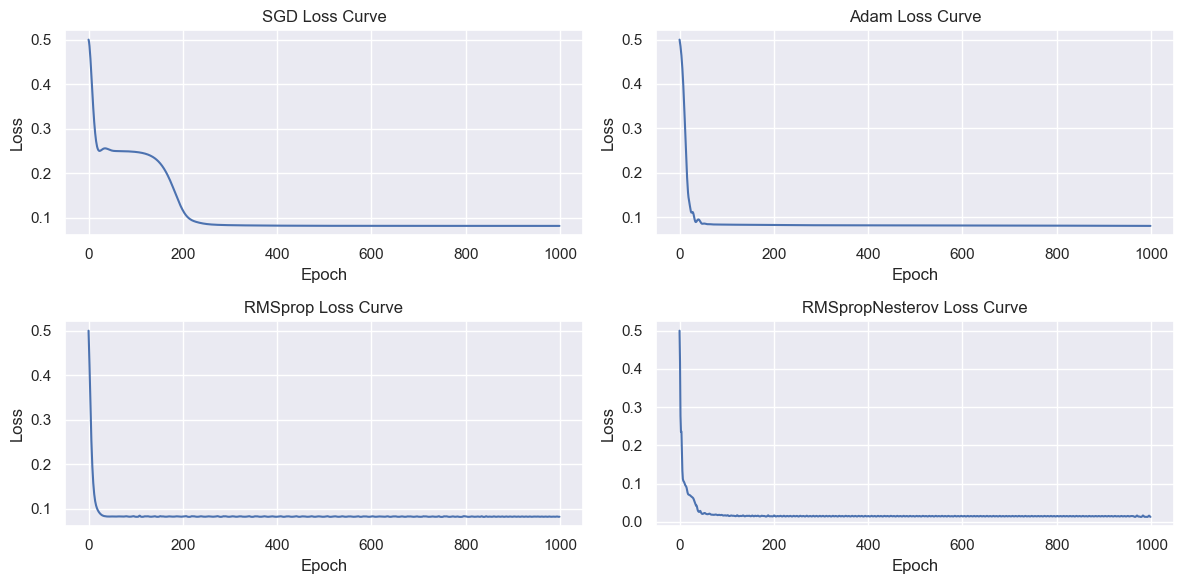

In [62]:
# Define optimizer parameters
optimizer_params = {
    "SGD": {"lr": 0.01, "momentum": 0.9},
    "Adam": {"lr": 0.01, "beta1": 0.9, "beta2": 0.999, "epsilon": 1e-8},
    "RMSprop": {"lr": 0.01, "beta1": 0.9, "epsilon": 1e-8},
    "RMSpropNesterov": {"lr": 0.01, "beta1": 0.9, "epsilon": 1e-8, "momentum": 0.9}
}

# Define optimizer names
optimizer_names = ["SGD", "Adam", "RMSprop", "RMSpropNesterov"]

# Train and plot
train_and_plot(optimizer_params.keys(), optimizer_params, X_train, y_train)